### **Importing Libraries**

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import copy
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torchvision.models as models
import tqdm
from torchvision import transforms
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **2.1**

#### **Loading Dataset**

In [2]:
data = pd.read_csv('data.csv')
data.head(1)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


#### **Handling Missing Values**

In [3]:
missing_data = data.apply(pd.isna).sum()
print("Missing data per column:\n", missing_data)

numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

categorical_columns = data.select_dtypes(include=[object]).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode().iloc[0])

remaining_missing = data.apply(pd.isna).sum()
print("\nRemaining missing values:\n", remaining_missing)

Missing data per column:
 Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

Remaining missing values:
 Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


#### **Plotting**

/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

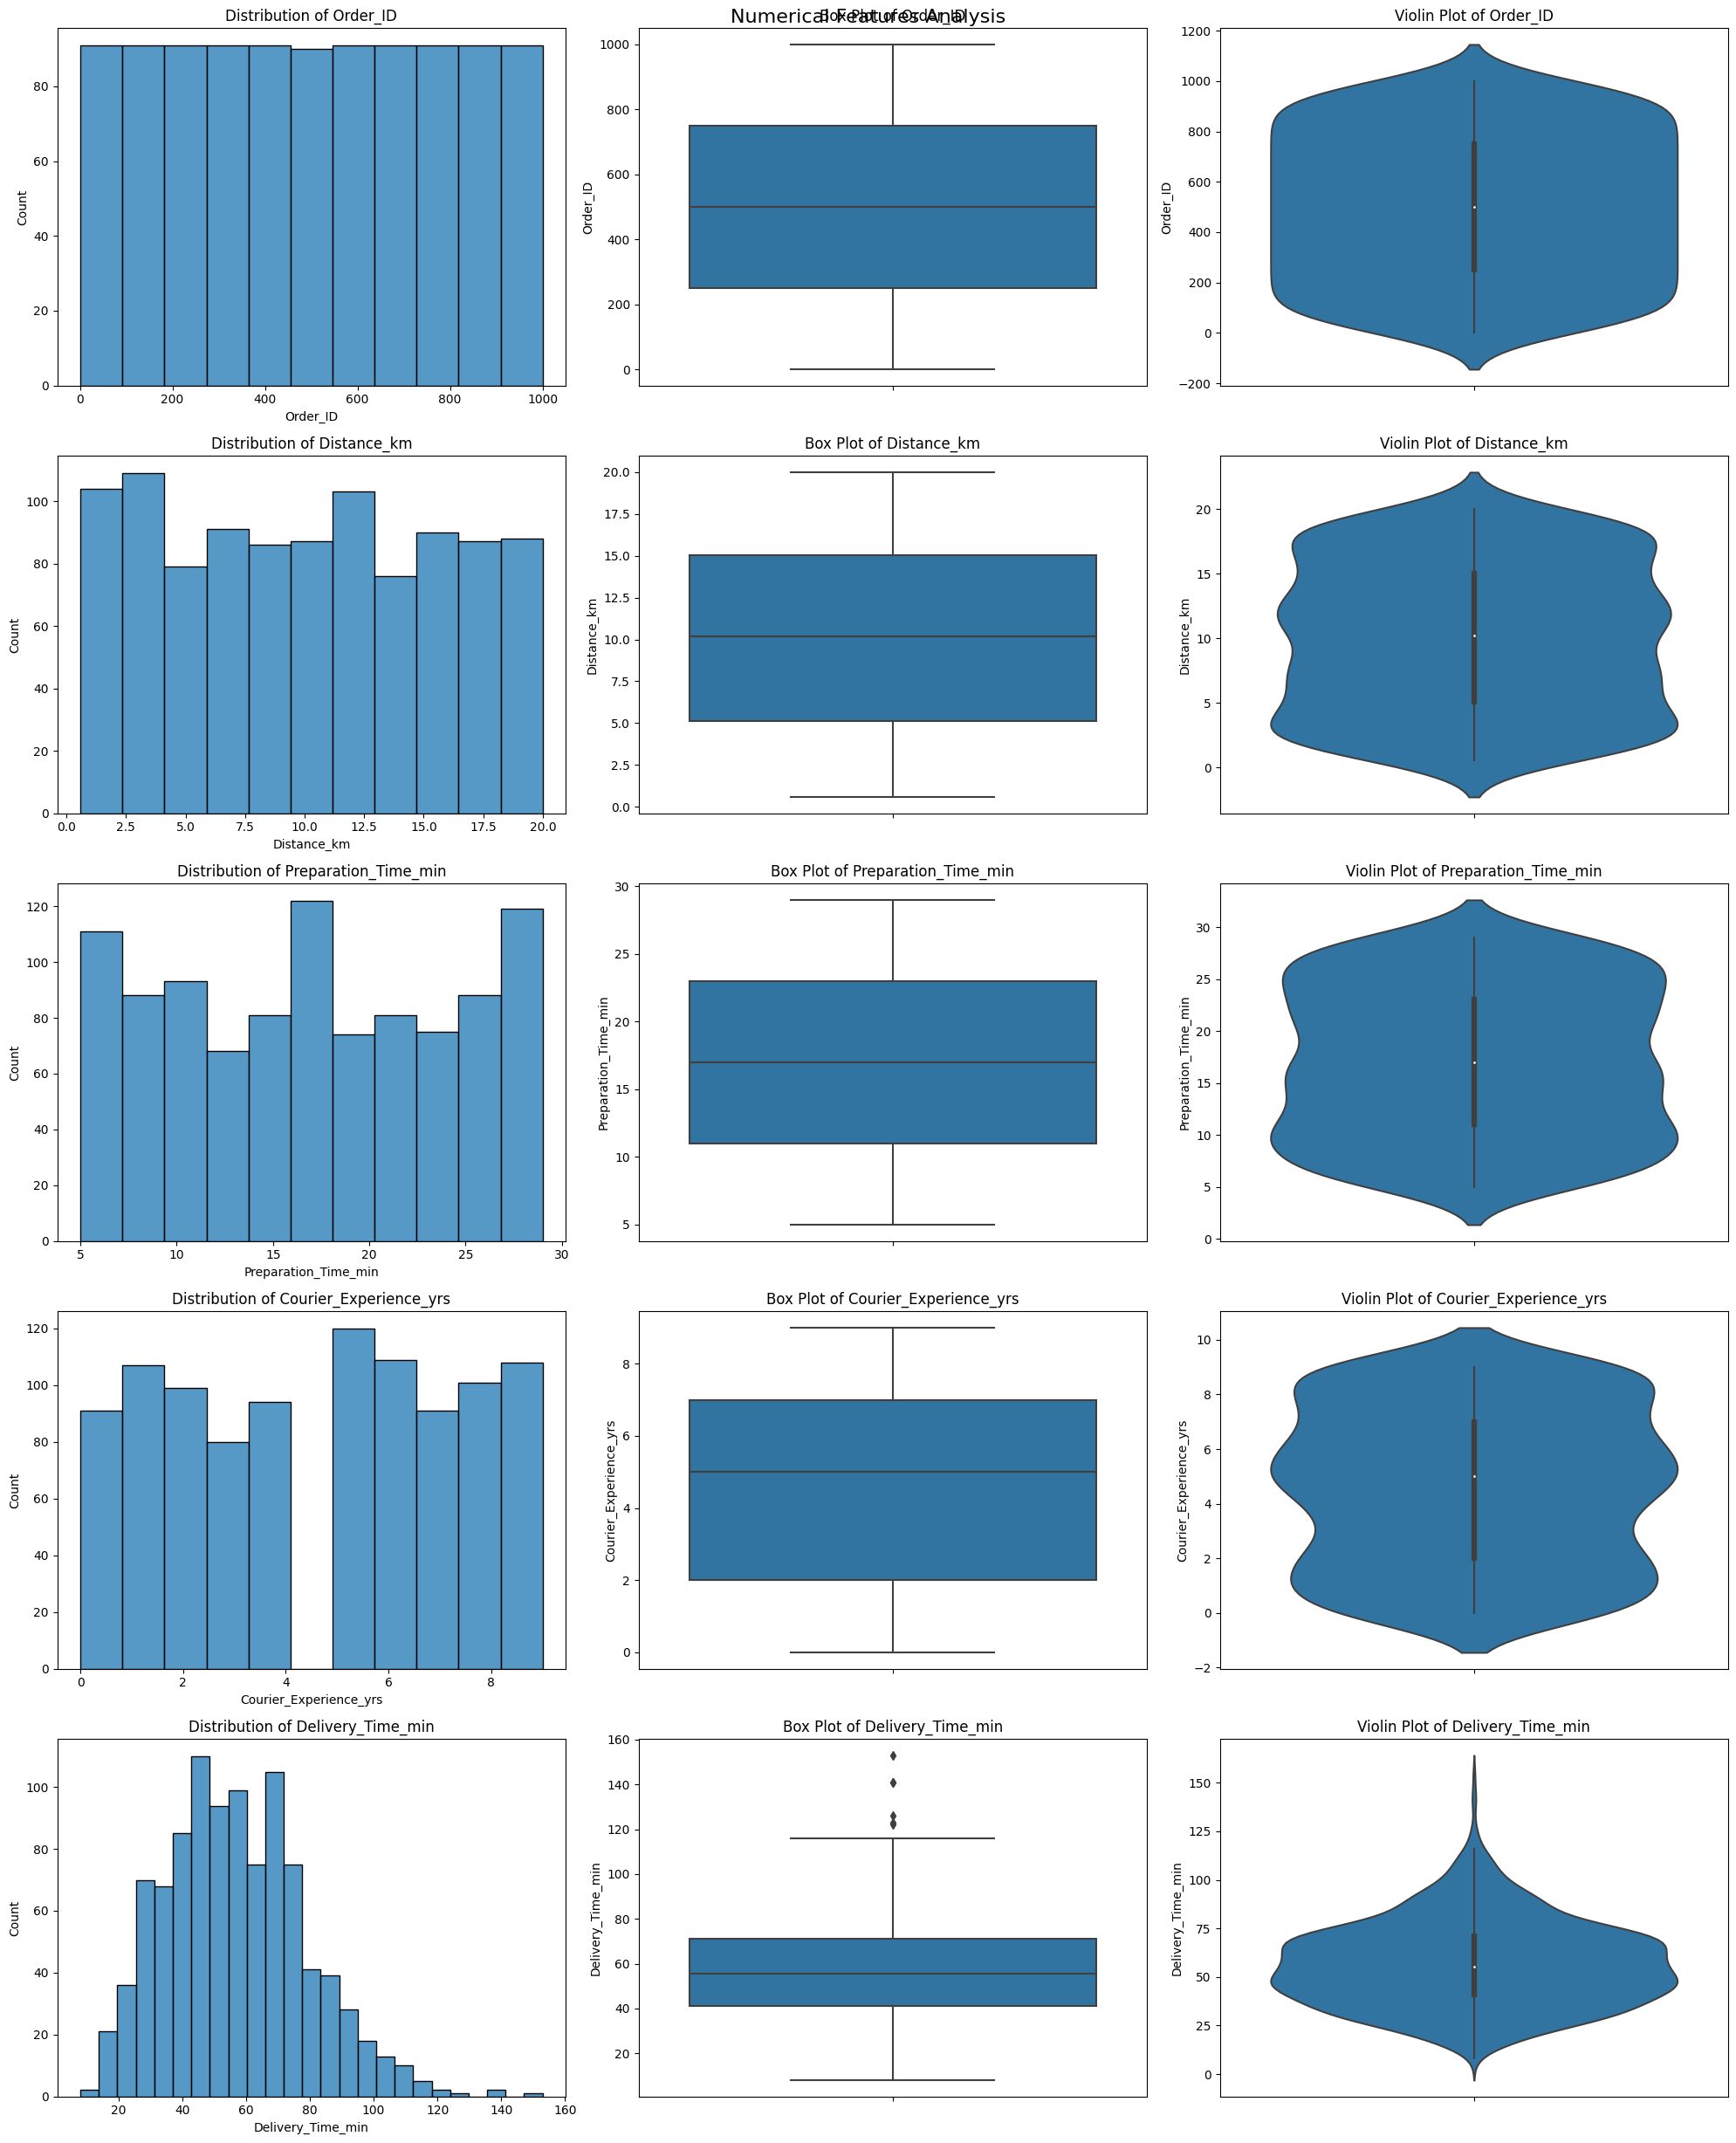

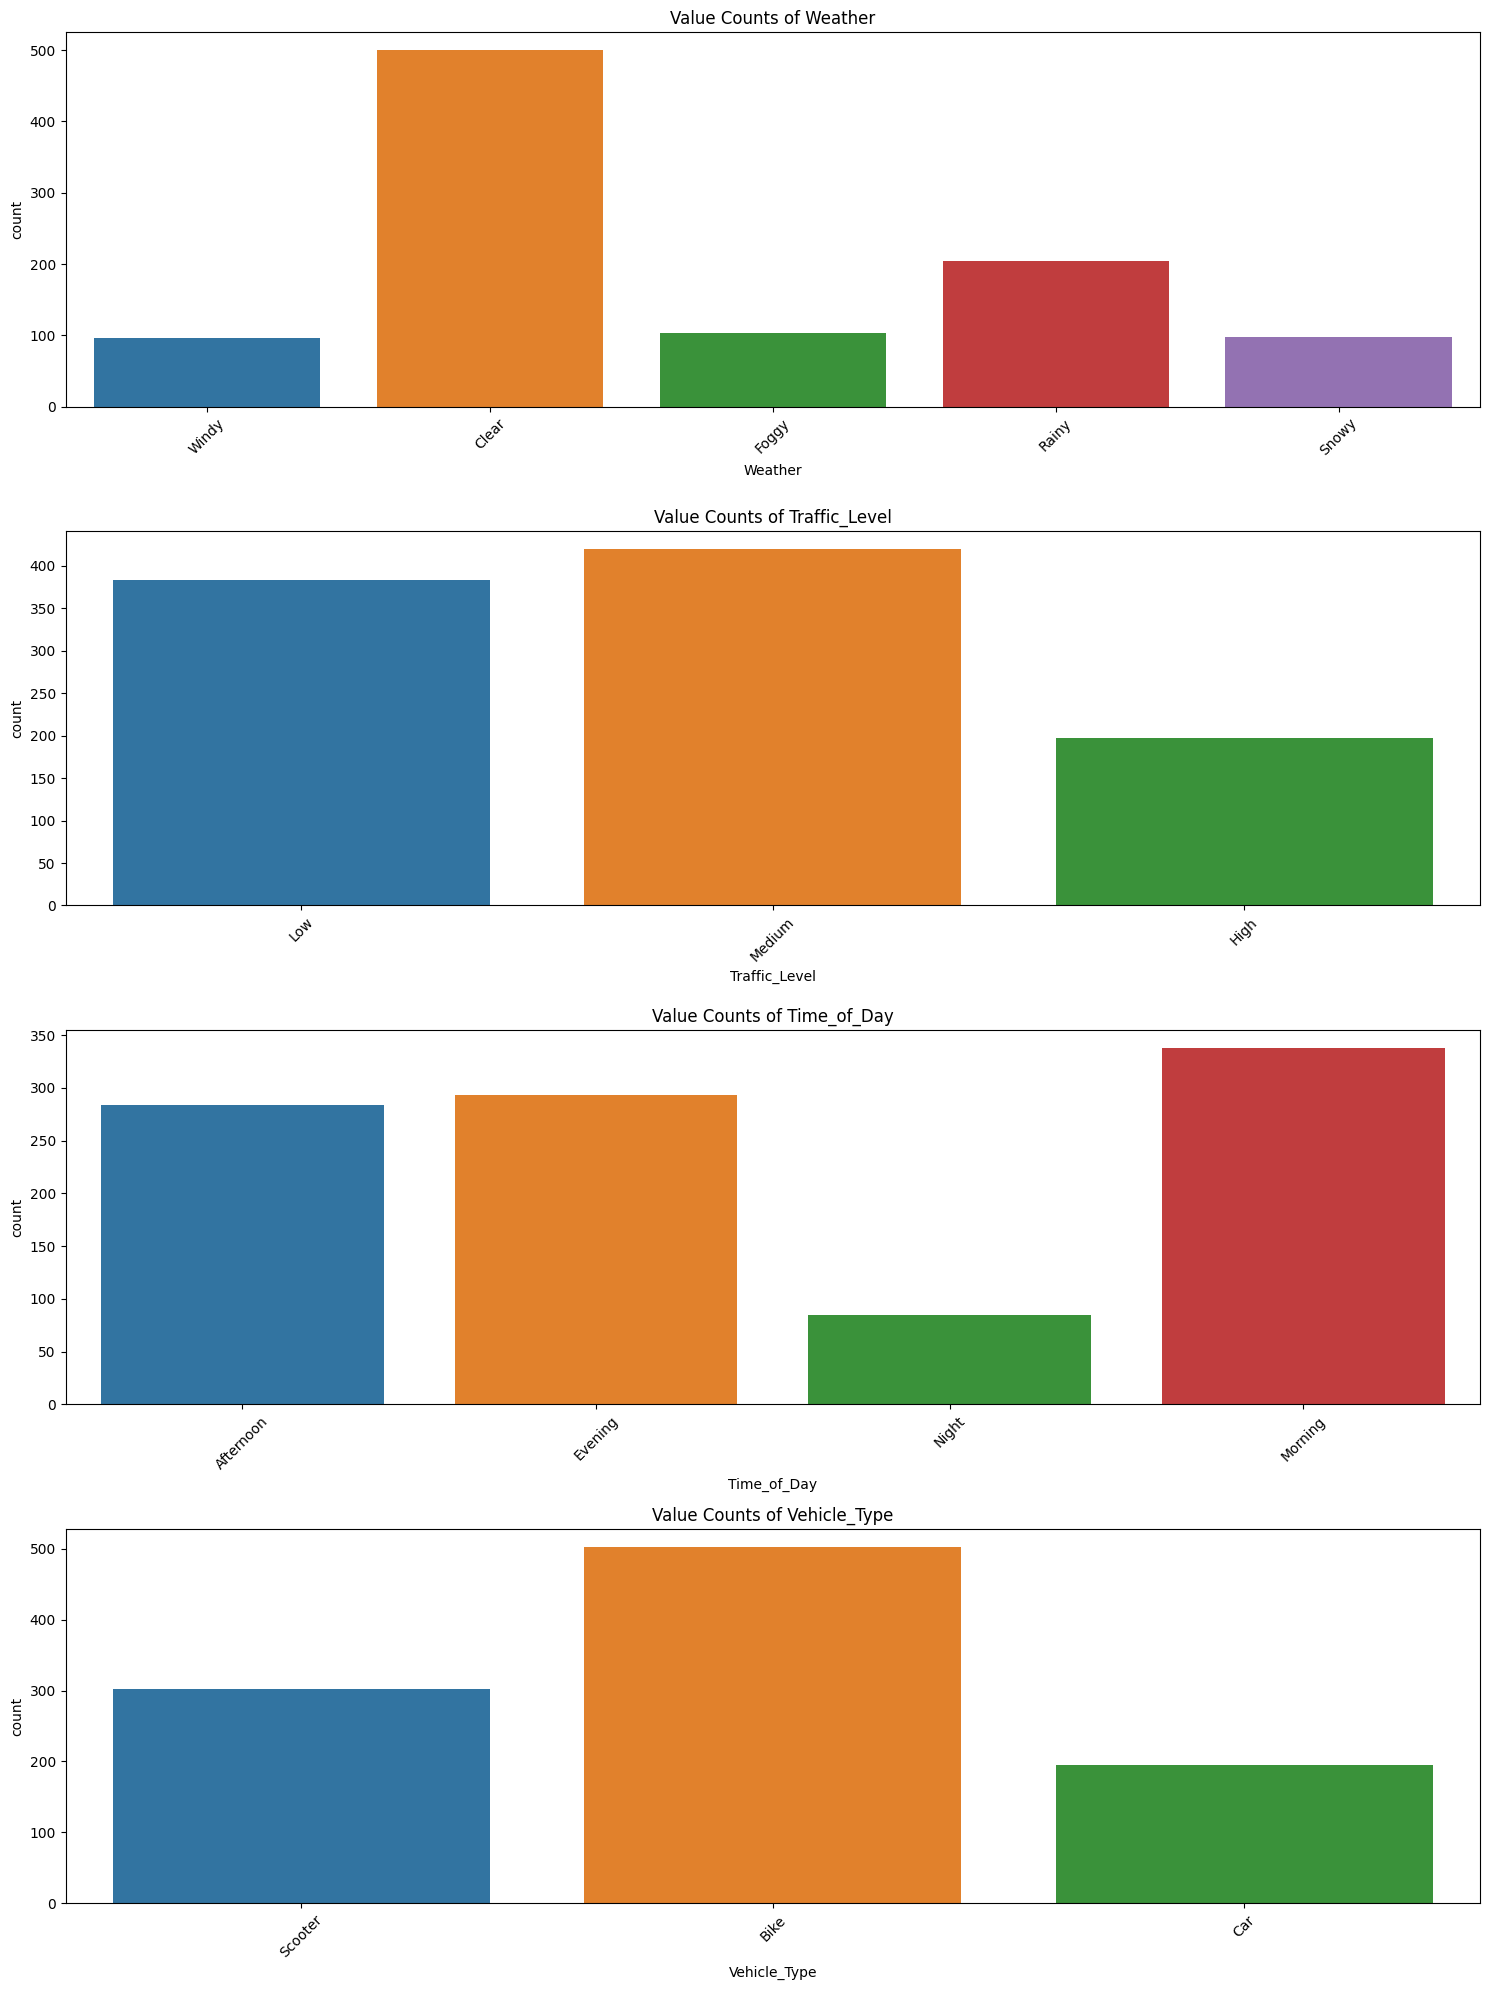


Numerical Features Summary:
          Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000  1000.000000           1000.000000             1000.000000   
mean    500.500000    10.059970             16.982000                4.592000   
std     288.819436     5.696656              7.204553                2.871198   
min       1.000000     0.590000              5.000000                0.000000   
25%     250.750000     5.105000             11.000000                2.000000   
50%     500.500000    10.190000             17.000000                5.000000   
75%     750.250000    15.017500             23.000000                7.000000   
max    1000.000000    19.990000             29.000000                9.000000   

       Delivery_Time_min  
count        1000.000000  
mean           56.732000  
std            22.070915  
min             8.000000  
25%            41.000000  
50%            55.500000  
75%            71.000000  
max           153.000000 

In [4]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(20, 5*len(numeric_cols)))
fig.suptitle('Numerical Features Analysis', fontsize=16)

for idx, col in enumerate(numeric_cols):

    sns.histplot(data=data, x=col, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Distribution of {col}')
    
    sns.boxplot(data=data, y=col, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Box Plot of {col}')
    
    sns.violinplot(data=data, y=col, ax=axes[idx, 2])
    axes[idx, 2].set_title(f'Violin Plot of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5*len(categorical_cols)))

for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, idx)
    sns.countplot(data=data, x=col)
    plt.title(f'Value Counts of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


print("\nNumerical Features Summary:")
print(data[numeric_cols].describe())

print("\nCategorical Features Summary:")
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())


#### **Splitting Data**

In [5]:
X = data.drop(columns=['Order_ID', 'Delivery_Time_min'])
y = data['Delivery_Time_min']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

train_data, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
val_data, test_data, y_val, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

train_transformed = preprocessor.fit_transform(train_data)
val_transformed = preprocessor.transform(val_data)
test_transformed = preprocessor.transform(test_data)

train_transformed_df = pd.DataFrame(train_transformed)
val_transformed_df = pd.DataFrame(val_transformed)
test_transformed_df = pd.DataFrame(test_transformed)

print(f"Number of datapoints in training set: {train_transformed_df.shape[0]}")
print(f"Number of datapoints in validation set: {val_transformed_df.shape[0]}")
print(f"Number of datapoints in test set: {test_transformed_df.shape[0]}")


Number of datapoints in training set: 700
Number of datapoints in validation set: 150
Number of datapoints in test set: 150


### **2.2**

#### **Gradient Descent**

In [6]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.05, n_iterations=1000, init_method='zero'):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.init_method = init_method
        self.train_losses = []
        self.val_losses = []
        
    def initialize_weights(self, n_features):
        if self.init_method == 'zero':
            self.weights = np.zeros(n_features)
            self.bias = 0
        else:
            self.weights = np.random.randn(n_features) * 0.01
            self.bias = np.random.randn() * 0.01
    
    def compute_loss(self, X, y):
        predictions = self.predict(X)
        return np.mean((predictions - y) ** 2)
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def evaluate_performance(self, X_test, y_test):
        predictions = self.predict(X_test)
        mse = np.mean((predictions - y_test) ** 2)
        r2 = r2_score(y_test, predictions)
        return mse, r2
    
    def batch_gradient_descent(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            predictions = self.predict(X_train)
            
            dw = (2/m) * np.dot(X_train.T, (predictions - y_train))
            db = (2/m) * np.sum(predictions - y_train)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
    
    def mini_batch_gradient_descent(self, X_train, y_train, X_val, y_val, batch_size=32):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                predictions = self.predict(X_batch)
                
                dw = (2/len(X_batch)) * np.dot(X_batch.T, (predictions - y_batch))
                db = (2/len(X_batch)) * np.sum(predictions - y_batch)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
    
    def stochastic_gradient_descent(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(m):
                X_i = X_shuffled[i:i+1]
                y_i = y_shuffled[i:i+1]
                
                prediction = self.predict(X_i)
                
                dw = 2 * np.dot(X_i.T, (prediction - y_i))
                db = 2 * (prediction - y_i)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break

#### **Plotting**

In [7]:
def plot_learning_curves(model_results, title):
    plt.figure(figsize=(12, 6))
    iterations = range(0, len(model_results['train_losses']) * 10, 10)
    
    plt.plot(iterations, model_results['train_losses'], label='Training Loss')
    plt.plot(iterations, model_results['val_losses'], label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.title(f'{title} Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

#### **Training the models**

Converged at iteration 670


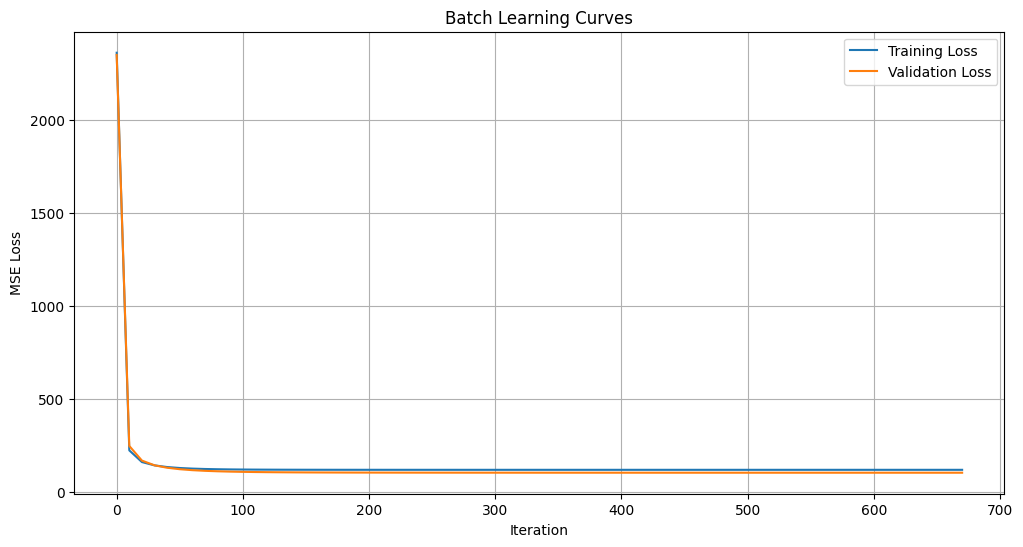

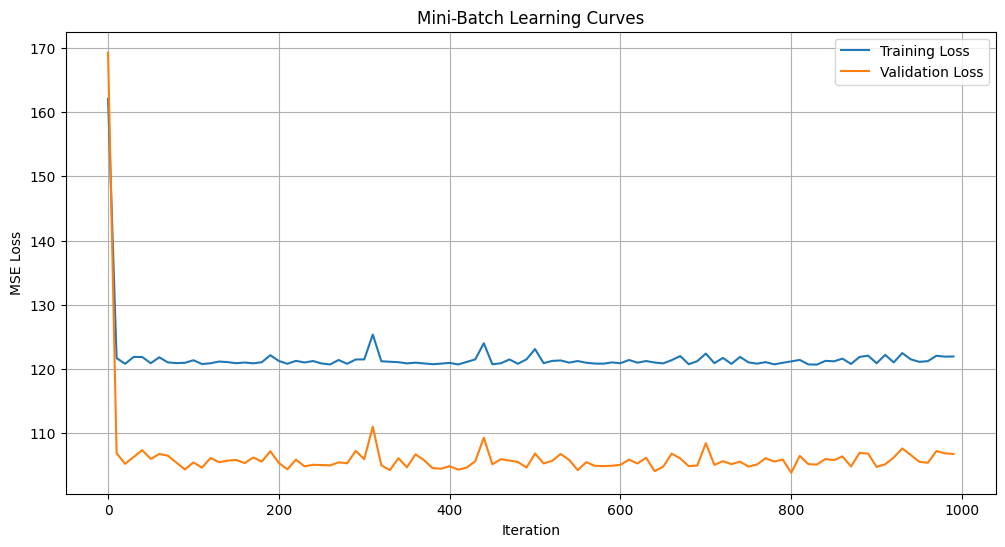

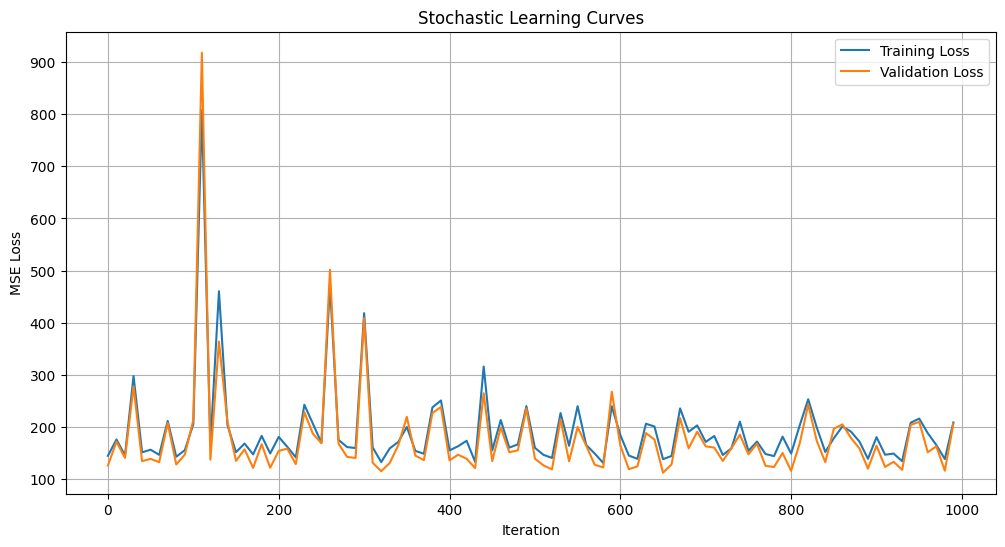


Final Performance Metrics:
------------------------------------------------------------
Method          Test MSE        R² Score       
------------------------------------------------------------
Batch           62.7530         0.8489         
Mini-Batch      61.8698         0.8510         
Stochastic      133.4998        0.6785         


In [8]:
X_train = train_transformed.toarray() if hasattr(train_transformed, 'toarray') else train_transformed
X_val = val_transformed.toarray() if hasattr(val_transformed, 'toarray') else val_transformed
X_test = test_transformed.toarray() if hasattr(test_transformed, 'toarray') else test_transformed
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

methods = {
    'Batch': lambda m: m.batch_gradient_descent(X_train, y_train, X_val, y_val),
    'Mini-Batch': lambda m: m.mini_batch_gradient_descent(X_train, y_train, X_val, y_val),
    'Stochastic': lambda m: m.stochastic_gradient_descent(X_train, y_train, X_val, y_val)
}

results = {}
for name, train_method in methods.items():
    model = LinearRegressionGD(learning_rate=0.05, n_iterations=1000)
    train_method(model)
    
    results[name] = {
        'train_losses': model.train_losses,
        'val_losses': model.val_losses
    }
    
    test_mse, test_r2 = model.evaluate_performance(X_test, y_test)
    results[name]['test_mse'] = test_mse
    results[name]['test_r2'] = test_r2
    
    plot_learning_curves(results[name], name)

print("\nFinal Performance Metrics:")
print("-" * 60)
print(f"{'Method':<15} {'Test MSE':<15} {'R² Score':<15}")
print("-" * 60)
for method, metrics in results.items():
    print(f"{method:<15} {metrics['test_mse']:<15.4f} {metrics['test_r2']:<15.4f}")


Training Ridge Regression...


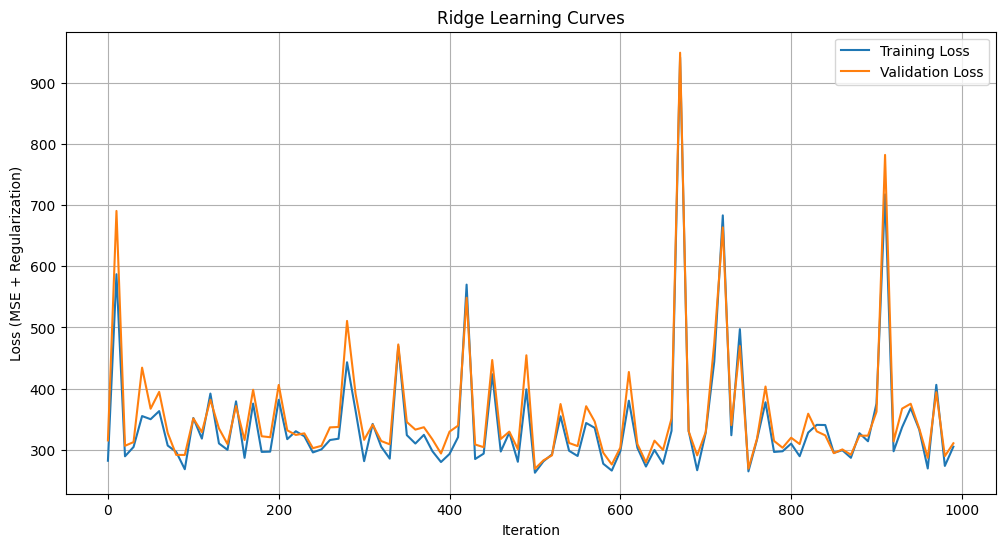


Ridge Regression Results:
Test MSE: 145.3832
R² Score: 0.6498
Average absolute coefficient value: 1.9599

Training Lasso Regression...


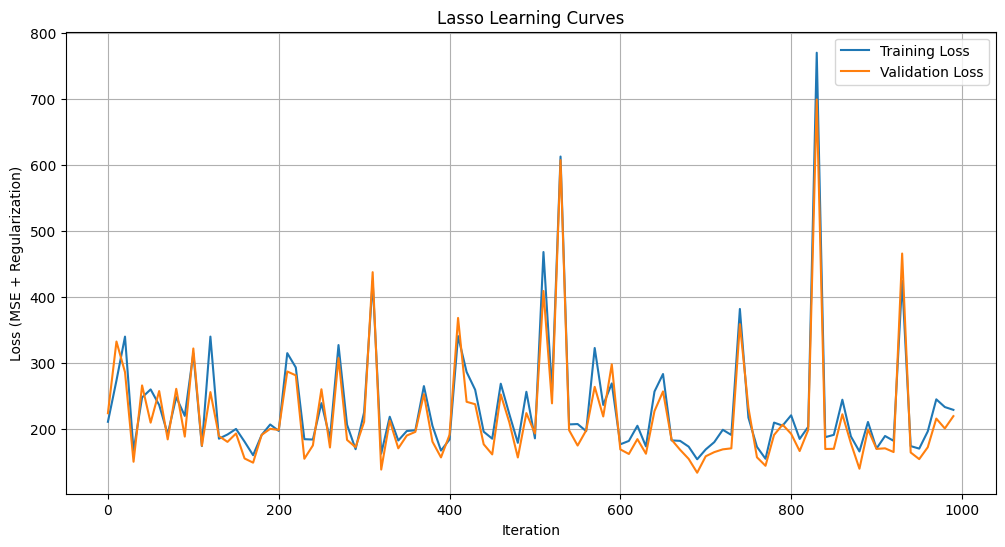


Lasso Regression Results:
Test MSE: 98.9012
R² Score: 0.7618
Average absolute coefficient value: 3.0096

Comparison Summary:
------------------------------------------------------------
Method          Test MSE        R² Score       
------------------------------------------------------------
Ridge           145.3832        0.6498         
Lasso           98.9012         0.7618         


In [13]:
class RegularizedRegression:
    def __init__(self, reg_type='ridge', learning_rate=0.05, lambda_param=0.5, n_iterations=1000):
        self.reg_type = reg_type
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.train_losses = []
        self.val_losses = []
        
    def initialize_weights(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def compute_loss(self, X, y):
        predictions = self.predict(X)
        mse = np.mean((predictions - y) ** 2)
        
        if self.reg_type == 'ridge':
            # L2 regularization term
            reg_term = self.lambda_param * np.sum(self.weights ** 2)
        else:  # lasso
            # L1 regularization term
            reg_term = self.lambda_param * np.sum(np.abs(self.weights))
            
        return mse + reg_term
    
    def compute_regularization_gradient(self):
        if self.reg_type == 'ridge':
            # Gradient of L2 regularization
            return 2 * self.lambda_param * self.weights
        else:  # lasso
            # Gradient of L1 regularization
            return self.lambda_param * np.sign(self.weights)
    
    def train(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(m):
                X_i = X_shuffled[i:i+1]
                y_i = y_shuffled[i:i+1]
                
                prediction = self.predict(X_i)
                
                # Compute gradients with regularization
                dw = 2 * np.dot(X_i.T, (prediction - y_i))
                reg_gradient = self.compute_regularization_gradient()
                dw += reg_gradient
                
                db = 2 * (prediction - y_i)
                
                # Update weights and bias
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            # Store training and validation losses every 10 iterations
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            # Early stopping if loss improvement is minimal
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"{self.reg_type.capitalize()} regression converged at iteration {iteration}")
                break
    
    def evaluate(self, X_test, y_test):
        predictions = self.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        return mse, r2

def plot_learning_curves(model, title):
    plt.figure(figsize=(12, 6))
    iterations = range(0, len(model.train_losses) * 10, 10)
    
    plt.plot(iterations, model.train_losses, label='Training Loss')
    plt.plot(iterations, model.val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (MSE + Regularization)')
    plt.title(f'{title} Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert sparse matrices to dense arrays if necessary
X_train = train_transformed.toarray() if hasattr(train_transformed, 'toarray') else train_transformed
X_val = val_transformed.toarray() if hasattr(val_transformed, 'toarray') else val_transformed
X_test = test_transformed.toarray() if hasattr(test_transformed, 'toarray') else test_transformed
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Train and evaluate Ridge and Lasso models
models = {
    'Ridge': RegularizedRegression(reg_type='ridge', lambda_param=0.5),
    'Lasso': RegularizedRegression(reg_type='lasso', lambda_param=0.5)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} Regression...")
    model.train(X_train, y_train, X_val, y_val)
    
    # Evaluate performance
    test_mse, test_r2 = model.evaluate(X_test, y_test)
    
    results[name] = {
        'model': model,
        'test_mse': test_mse,
        'test_r2': test_r2
    }
    
    # Plot learning curves
    plot_learning_curves(model, name)
    
    # Calculate number of near-zero coefficients (for feature selection analysis)
    near_zero_coef = np.sum(np.abs(model.weights) < 1e-4)
    print(f"\n{name} Regression Results:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"R² Score: {test_r2:.4f}")
    print(f"Average absolute coefficient value: {np.mean(np.abs(model.weights)):.4f}")

# Compare with unregularized model
print("\nComparison Summary:")
print("-" * 60)
print(f"{'Method':<15} {'Test MSE':<15} {'R² Score':<15}")
print("-" * 60)
for method, metrics in results.items():
    print(f"{method:<15} {metrics['test_mse']:<15.4f} {metrics['test_r2']:<15.4f}")



Training Ridge models with different λ values...

Training Lasso models with different λ values...


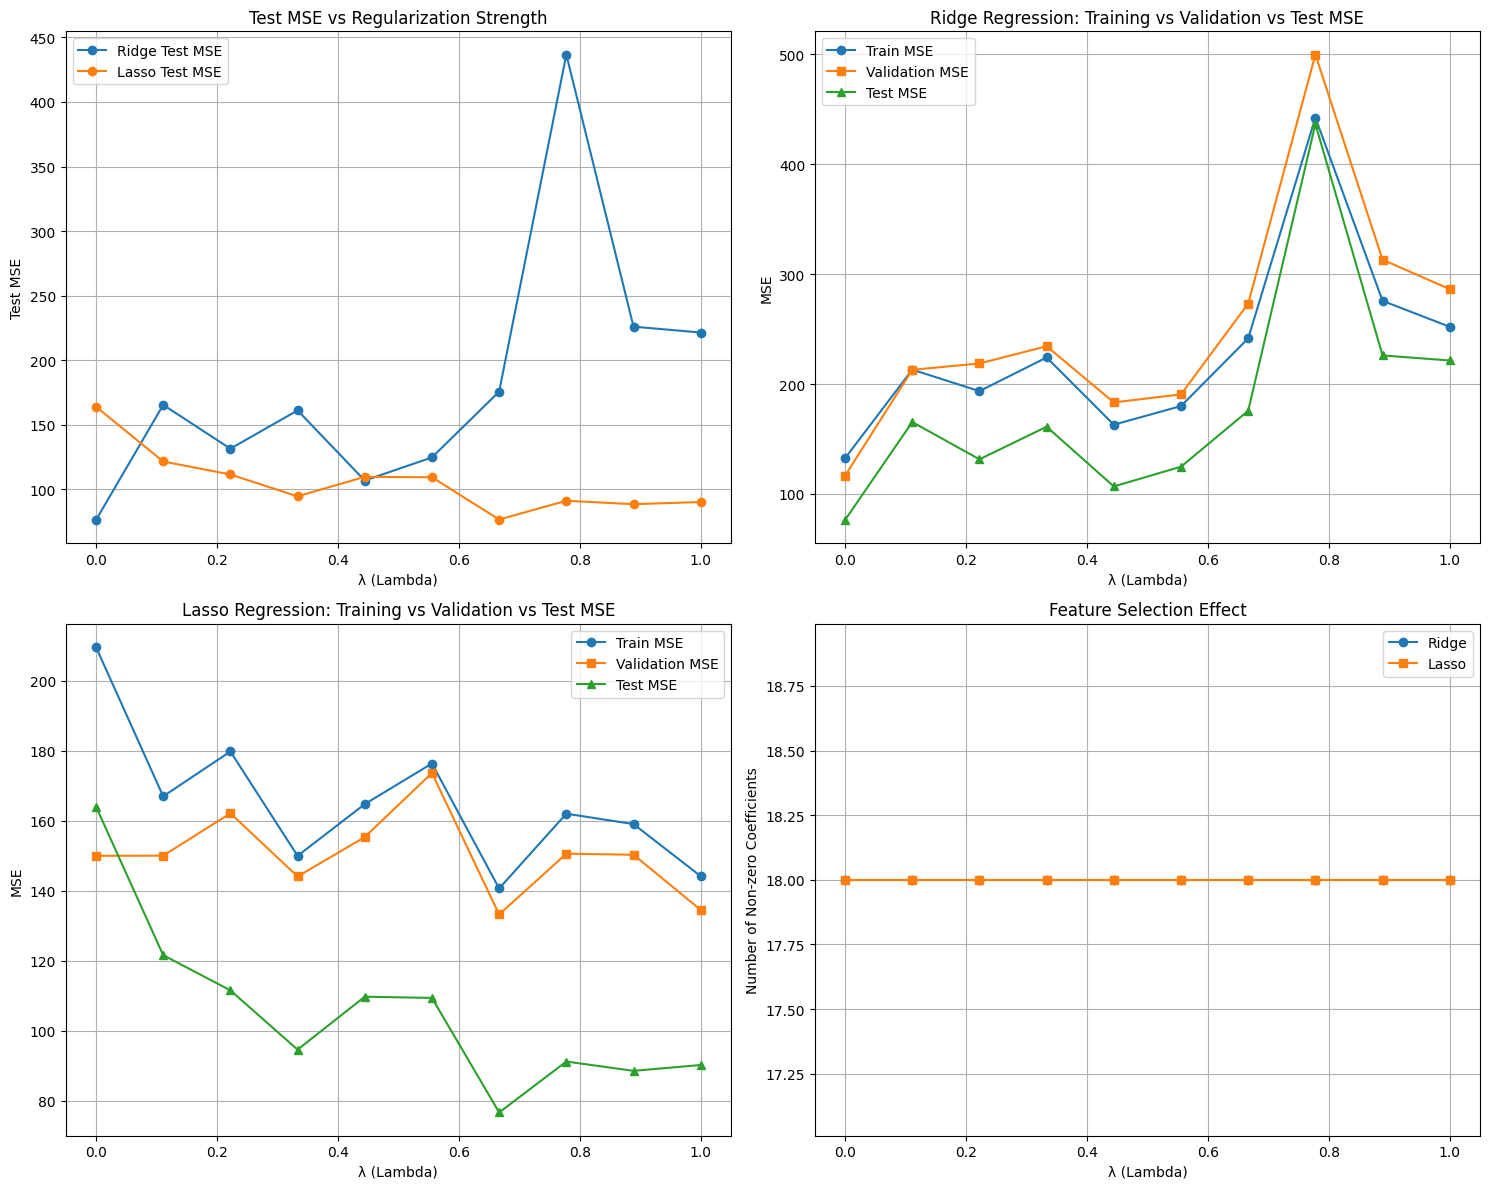


Optimal Regularization Parameters:
Ridge optimal λ: 0.0000
Lasso optimal λ: 0.6667

Minimum Test MSE Values:
Ridge: 76.2664
Lasso: 76.5891


In [11]:
def analyze_regularization_impact(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define lambda values
    lambda_values = np.linspace(0, 1, 10)
    
    # Store results for both Ridge and Lasso
    results = {
        'ridge': {'test_mse': [], 'train_mse': [], 'val_mse': [], 'nonzero_coef': []},
        'lasso': {'test_mse': [], 'train_mse': [], 'val_mse': [], 'nonzero_coef': []}
    }
    
    for reg_type in ['ridge', 'lasso']:
        print(f"\nTraining {reg_type.capitalize()} models with different λ values...")
        
        for lambda_param in lambda_values:
            model = RegularizedRegression(reg_type=reg_type, lambda_param=lambda_param)
            model.train(X_train, y_train, X_val, y_val)
            
            # Calculate MSE for train, validation and test sets
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            results[reg_type]['train_mse'].append(mean_squared_error(y_train, train_pred))
            results[reg_type]['val_mse'].append(mean_squared_error(y_val, val_pred))
            results[reg_type]['test_mse'].append(mean_squared_error(y_test, test_pred))
            
            # Count non-zero coefficients
            nonzero_coef = np.sum(np.abs(model.weights) > 1e-4)
            results[reg_type]['nonzero_coef'].append(nonzero_coef)
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot MSE vs lambda for both methods
    for reg_type in ['ridge', 'lasso']:
        ax1.plot(lambda_values, results[reg_type]['test_mse'], 
                label=f'{reg_type.capitalize()} Test MSE', marker='o')
    ax1.set_xlabel('λ (Lambda)')
    ax1.set_ylabel('Test MSE')
    ax1.set_title('Test MSE vs Regularization Strength')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training vs validation vs test MSE for Ridge
    ax2.plot(lambda_values, results['ridge']['train_mse'], label='Train MSE', marker='o')
    ax2.plot(lambda_values, results['ridge']['val_mse'], label='Validation MSE', marker='s')
    ax2.plot(lambda_values, results['ridge']['test_mse'], label='Test MSE', marker='^')
    ax2.set_xlabel('λ (Lambda)')
    ax2.set_ylabel('MSE')
    ax2.set_title('Ridge Regression: Training vs Validation vs Test MSE')
    ax2.legend()
    ax2.grid(True)
    
    # Plot training vs validation vs test MSE for Lasso
    ax3.plot(lambda_values, results['lasso']['train_mse'], label='Train MSE', marker='o')
    ax3.plot(lambda_values, results['lasso']['val_mse'], label='Validation MSE', marker='s')
    ax3.plot(lambda_values, results['lasso']['test_mse'], label='Test MSE', marker='^')
    ax3.set_xlabel('λ (Lambda)')
    ax3.set_ylabel('MSE')
    ax3.set_title('Lasso Regression: Training vs Validation vs Test MSE')
    ax3.legend()
    ax3.grid(True)
    
    # Plot number of non-zero coefficients
    ax4.plot(lambda_values, results['ridge']['nonzero_coef'], 
             label='Ridge', marker='o')
    ax4.plot(lambda_values, results['lasso']['nonzero_coef'], 
             label='Lasso', marker='s')
    ax4.set_xlabel('λ (Lambda)')
    ax4.set_ylabel('Number of Non-zero Coefficients')
    ax4.set_title('Feature Selection Effect')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal lambda values
    ridge_opt_lambda = lambda_values[np.argmin(results['ridge']['test_mse'])]
    lasso_opt_lambda = lambda_values[np.argmin(results['lasso']['test_mse'])]
    
    print("\nOptimal Regularization Parameters:")
    print(f"Ridge optimal λ: {ridge_opt_lambda:.4f}")
    print(f"Lasso optimal λ: {lasso_opt_lambda:.4f}")
    
    # Print minimum MSE values
    print("\nMinimum Test MSE Values:")
    print(f"Ridge: {min(results['ridge']['test_mse']):.4f}")
    print(f"Lasso: {min(results['lasso']['test_mse']):.4f}")

# Run the analysis
analyze_regularization_impact(X_train, y_train, X_val, y_val, X_test, y_test)